In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing import image
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# This uses the preprocessing library to import and augment images. The images
# are then converted to a simple numpy array
datagen = image.ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2,
    dtype="float32"
)

train = datagen.flow_from_directory(
    "../../leabra",
    target_size=(100, 100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
    subset="training"
)

test = datagen.flow_from_directory(
    "../../leabra",
    target_size=(100, 100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
    subset="validation"
)

x_train, y_train = train.next()
x_test, y_test = test.next()

Found 992 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


In [4]:
input_shape = x_train[0].shape
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

(100, 100, 1)
2


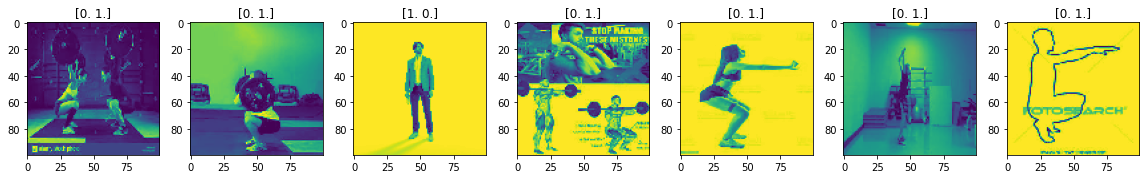

In [5]:
plt.figure(figsize=(20, 20))  # specifying the overall grid size

for i in range(7):
    plt.subplot(7, 7, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(x_train[i])
plt.show()

In [6]:
model = keras.Sequential()

# model.add(keras.layers.Conv2D(512, (6,6), activation='relu', input_shape=input_shape))

model.add(keras.layers.Conv2D(128, (6, 6),
                              activation='relu',
                              input_shape=input_shape))
model.add(keras.layers.Conv2D(256, (4, 4), activation='relu'))

model.add(keras.layers.BatchNormalization(momentum=0.3))
model.add(keras.layers.MaxPooling2D(pool_size=(4,4)))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(output_shape, activation='softmax'))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 95, 95, 128)       4736      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 256)       524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [7]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/50
31/31 [==============================] - 10s 114ms/step - loss: 16.7826 - categorical_accuracy: 0.5401 - val_loss: 11.8602 - val_categorical_accuracy: 0.5506
Epoch 2/50
31/31 [==============================] - 3s 81ms/step - loss: 8.1225 - categorical_accuracy: 0.5887 - val_loss: 1.9921 - val_categorical_accuracy: 0.5789
Epoch 3/50
31/31 [==============================] - 2s 79ms/step - loss: 1.7379 - categorical_accuracy: 0.6091 - val_loss: 0.8958 - val_categorical_accuracy: 0.6761
Epoch 4/50
31/31 [==============================] - 2s 79ms/step - loss: 0.7567 - categorical_accuracy: 0.6559 - val_loss: 0.6360 - val_categorical_accuracy: 0.6883
Epoch 5/50
31/31 [==============================] - 2s 80ms/step - loss: 0.5990 - categorical_accuracy: 0.7456 - val_loss: 0.7200 - val_categorical_accuracy: 0.7126
Epoch 6/50
31/31 [==============================] - 2s 79ms/step - loss: 0.4634 - categorical_accuracy: 0.7873 - val_loss: 0.6723 - val_categorical_accuracy: 0.7166
Epoch 

Test loss: 1.0325907468795776
Test accuracy: 0.8178137540817261


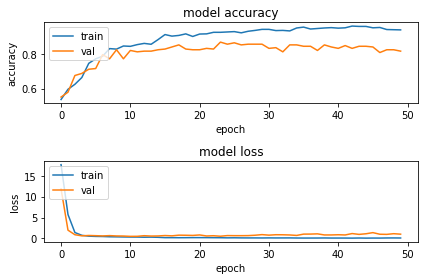

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

### Verify the predictions being made
---

In [9]:
def decoder(one_pred):
    if one_pred[0] > one_pred[1]:
        return np.float32([1, 0])
    else:
        return [0, 1]


squat_preds = model.predict(x_test)
decoded = np.apply_along_axis(decoder, 1, squat_preds)

incorrect_squats = []
incorrect_non_squats = []

for i in range(len(y_test)):
    if (np.array_equal(decoded[i], y_test[i])) is False:
        if y_test[i][0] == 1:
            incorrect_non_squats.append(i)
        else:
            incorrect_squats.append(i)

print(len(incorrect_squats))
print(len(incorrect_non_squats))

for i in incorrect_non_squats:
    plt.imshow(image.array_to_img(x_test[i, :, :, :]))
    plt.title(str(squat_preds[i]))
    plt.show()

print()

for i in incorrect_squats:
    plt.imshow(image.array_to_img(x_test[i, :, :, :]))
    plt.title(str(squat_preds[i]))
    plt.show()


NameError: name 'Y' is not defined